<a href="https://colab.research.google.com/github/ak471909/facial-recognition-transfer-learning/blob/main/transfer_learning_celebs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data preprocessing

### Data download

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Celebrity Faces dataset contains folders for 17 different celebrities and each folder contains 100 images (160x160) of them.

Resource: https://www.kaggle.com/datasets/vishesh1412/celebrity-face-image-dataset

In [ ]:
import zipfile

zip_file_path = '/content/drive/MyDrive/Celebrity Faces Dataset.zip'
extract_to_path = '/content/extracted_folder/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

In [ ]:
PATH = os.path.join(extract_to_path, 'Celebrity Faces Dataset')

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [ ]:
all_dataset = tf.keras.utils.image_dataset_from_directory(PATH,
                                                          shuffle=True,
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE)

Found 1700 files belonging to 17 classes.


Dividing a TensorFlow dataset ("all_dataset") into training, validation, and test subsets.

In [ ]:
# Calculate the total number of elements (or batches) in the all_dataset to determine how to split the dataset
all_batches = tf.data.experimental.cardinality(all_dataset)

# Take the first 1/5 (20%) of the all_dataset to be used as the test dataset
test_dataset = all_dataset.take(all_batches // 5)

# Skip the first 1/5 of the dataset (test dataset)
# Create train_val_dataset which contains the remaining 80% of the data
train_val_dataset = all_dataset.skip(all_batches // 5)

# Take the first 1/5 of train_val_dataset and assign it to the validation dataset
validation_dataset = train_val_dataset.take(all_batches // 5)

# Skip the first 1/5 (which corresponds to the validation set) to get the training dataset
train_dataset = train_val_dataset.skip(all_batches // 5)

In [ ]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 34
Number of validation batches: 10
Number of test batches: 10


Visualize a batch of images from the train_dataset labeling them with their respective class names

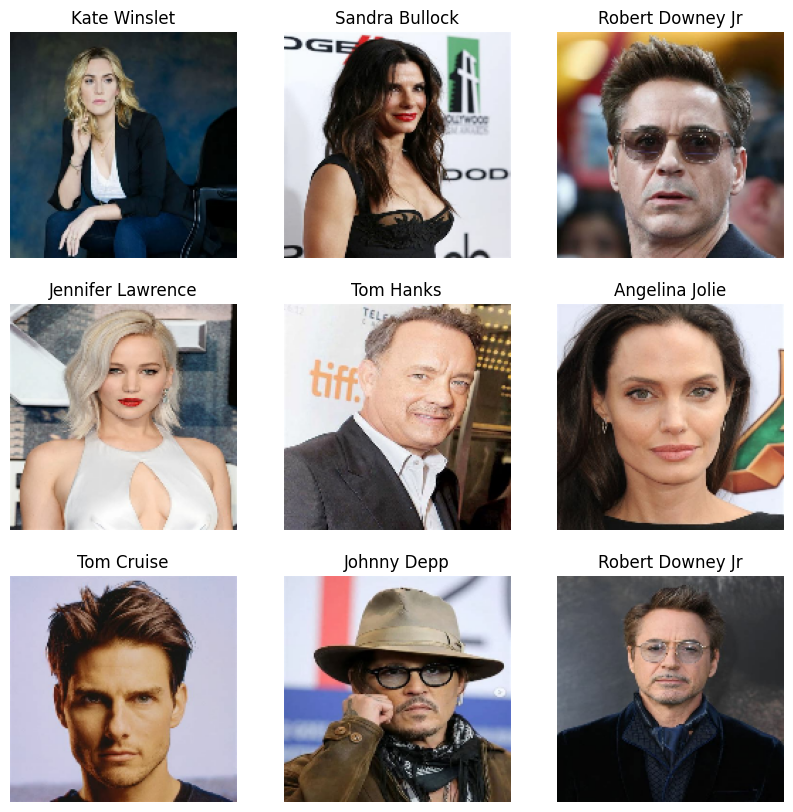

In [ ]:
class_names = all_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Configure the dataset for performance

In [ ]:
# For efficient data loading using buffered prefetching to load images from disk without having I/O become blocking

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When the image dataset is small, it's helpful to increase variety by applying random, realistic transformations like rotation and horizontal flipping to the training images. This exposes the model to more diverse data and helps prevent overfitting.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

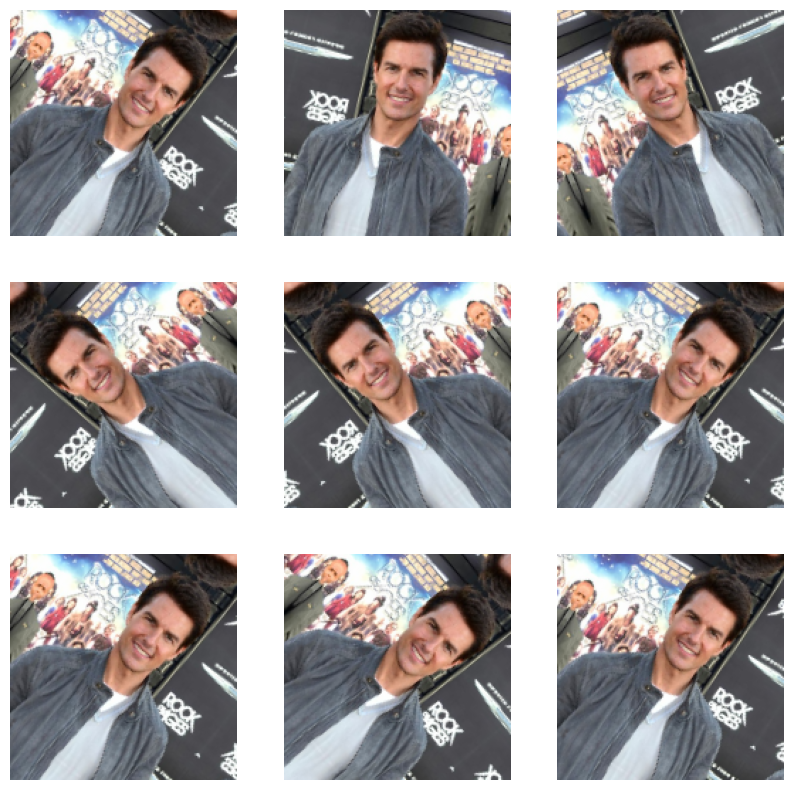

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

The model `tf.keras.applications.MobileNetV2` expects pixel values in `[-1, 1]` (link to documentation: https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2). The pixel values in our images are in `[0, 255]`. To rescale them, we use the preprocessing method included with the model.

In [ ]:
# Rescale the pixel values from the [0, 255] range to the [-1, 1] range

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Create the base model from the pre-trained convnets



In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


This code extracts the feature map from the bottleneck layer of the MobileNetV2 model, showing the output shape, which reflects the 1280 learned feature channels.

In [ ]:
# Image batch has a shape (batch_size=32, height=160, width=160, and channels=3)
image_batch, label_batch = next(iter(train_dataset))

# Pass the batch of images through the base model without the classification layer
feature_batch = base_model(image_batch)

print(feature_batch.shape)

(32, 5, 5, 1280)


### Freeze the convolutional base

It's important to freeze the convolutional base of the model before compiling and training it (set trainable = False), which prevents the weights of those layers from being updated during training => allow to only train the new layers we are adding on top.

In [ ]:
base_model.trainable = False

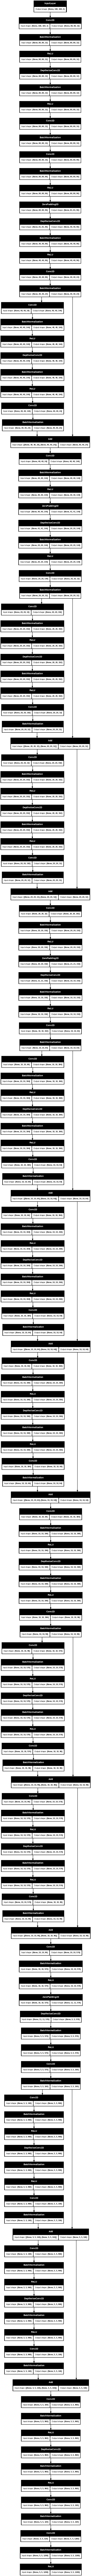

In [ ]:
tf.keras.utils.plot_model(base_model, show_shapes=True, expand_nested=True, dpi=64)

### Add a classification head

To compress the 2D spatial feature map (5x5) into a single value per feature map global average pooling is applied. It gives a single number for each feature map (channel), resulting in a vector of 1280 values, each representing the average of one feature channel over the entire spatial grid.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Convert the feature vector (after global average pooling) into a single prediction for each image.
17 is the number of classes in our classification task (17 celebrities).
Activation function 'softmax' because it's a multi-class classification.

In [ ]:
# Creates a fully connected (dense) layer that will output 17 values for each image.
prediction_layer = tf.keras.layers.Dense(17, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 17)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers.

In [ ]:
# Input layer with images with 160x160 pixels with 3 color channels (RGB)
inputs = tf.keras.Input(shape=(160, 160, 3))

# Artificially increase the size and diversity of the dataset by applying random transformations
x = data_augmentation(inputs)

# Rescale images pixel values to adjust to MobileNet V2 model, which is in the range [-1, 1]
x = preprocess_input(x)

# Base model
x = base_model(x, training=False)

# Global average pooling to capture global features of the image
x = global_average_layer(x)

x = tf.keras.layers.Dropout(0.2)(x)

# Dense layer for learning higher-level patterns and combining the features extracted by the base model
x = tf.keras.layers.Dense(1280, activation='relu')(x)

# Final output layer
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_5 (TrueDivide)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_5 (Subtract)                │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1280)                │       1,639,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 17)                  │          21,777 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,919,441 (14.95 MB)

 Trainable params: 1,661,457 (6.34 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Compile the model

We use SparseCategoricalCrossentropy because it's a multi-class classification problems.

For metrics Accuracy is set to check if the predicted class matches the true class.

In [ ]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [ ]:
initial_epochs = 850

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/850
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.1105 - loss: 2.9973 - val_accuracy: 0.2375 - val_loss: 2.3703
Epoch 2/850
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.2319 - loss: 2.3461 - val_accuracy: 0.2656 - val_loss: 2.1457
Epoch 3/850
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.3362 - loss: 2.0826 - val_accuracy: 0.2812 - val_loss: 2.0268
Epoch 4/850
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.3806 - loss: 1.8767 - val_accuracy: 0.3656 - val_loss: 1.8220
Epoch 5/850
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.4353 - loss: 1.7303 - val_accuracy: 0.3656 - val_loss: 1.7891
Epoch 6/850
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.4472 - loss: 1.6421 - val_accuracy: 0.4094 - val_loss: 1.6811
Epoch 7/850
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.5264 - loss: 1.4764 - val_accuracy: 0.4156 - val_loss: 1.6503
Epoch 8/850
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.5522 - loss: 1.3812 - val_accuracy: 

In [ ]:
# Saving the model to be able to return to this state later.
model.save('model_with_frozen_conv_base.keras')

Training Accuracy generally improves across the epochs, increasing to ≈0.99. This indicates that the model is learning from the training data and getting better at classifying the training set.

Validation Accuracy reached ≈0.96-0.97, which is quite good.

### Learning curves

The learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

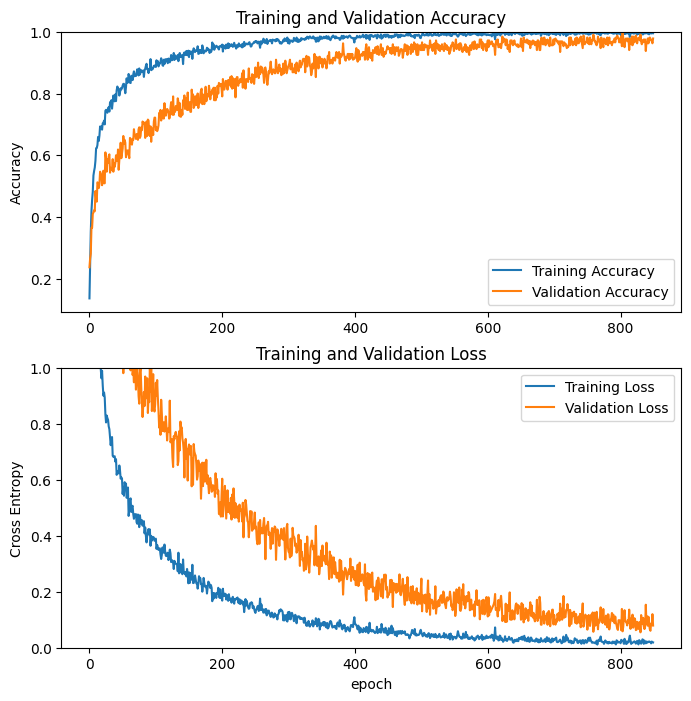

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

### Un-freeze the top layers of the model


Next step - unfreeze the `base_model` and set the bottom layers to be un-trainable. Then recompile the model and resume training.

In [ ]:
base_model.trainable = True

In [ ]:
# Check how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

In [ ]:
# Optimizer changed to RMSprop because is often preferred for fine-tuning pre-trained models
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1280)                │       1,639,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 17)                  │          21,777 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,919,441 (14.95 MB)

 Trainable params: 3,522,897 (13.44 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [ ]:
len(model.trainable_variables)

58

### Continue training the model

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 851/860
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.5051 - loss: 2.1331 - val_accuracy: 0.9594 - val_loss: 0.1012
Epoch 852/860
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.5697 - loss: 1.6213 - val_accuracy: 0.9625 - val_loss: 0.1007
Epoch 853/860
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.6220 - loss: 1.2433 - val_accuracy: 0.9719 - val_loss: 0.1023
Epoch 854/860
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.6533 - loss: 1.2299 - val_accuracy: 0.9719 - val_loss: 0.1313
Epoch 855/860
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.6646 - loss: 1.0974 - val_accuracy: 0.9594 - val_loss: 0.1436
Epoch 856/860
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.7144 - loss: 0.9495 - val_accuracy: 0.9531 - val_loss: 0.1793
Epoch 857/860
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.6896 - loss: 1.0105 - val_accuracy: 0.9500 - val_loss: 0.1731
Epoch 858/860
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.7180 - loss: 0.9228

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

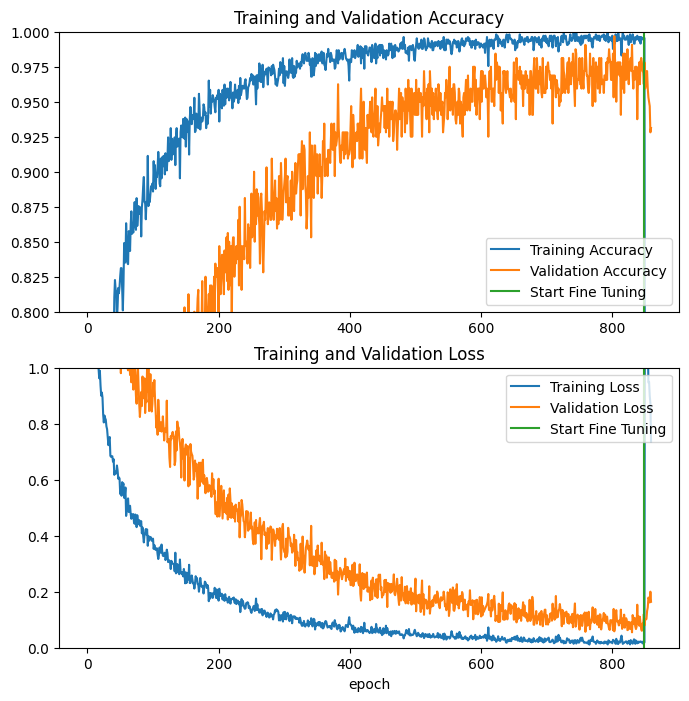

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

After fine-tuning the model, the accuracy on the validation set decreased to 0.93. So, in our case the fine-tuning makes the performance worse. It might mean that the pre-trained model is already very close to the optimal solution for our dataset, and it's unnecessary to adjust already well-trained weights. Therefore, we will use the model with the frozen convolutional layers, saved before.

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('model_with_frozen_conv_base.keras')

### Evaluation and prediction

Verify the performance of the model on new data using test set.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9442 - loss: 0.1532
Test accuracy : 0.940625011920929


Predictions:
 [ 4 13  3  1  1  0  4  9  6  6 14  9 15 13  6 16  0  1  5  9  2  7  3  4
  1 10  5  4 16 16  1  0]
Labels:
 [ 4 13  3  1  1  0  4  9  6  6 14  8 15 13  6 16  0  1  5  9  2  7  3  4
  1 10  5  4 16 16  1  9]


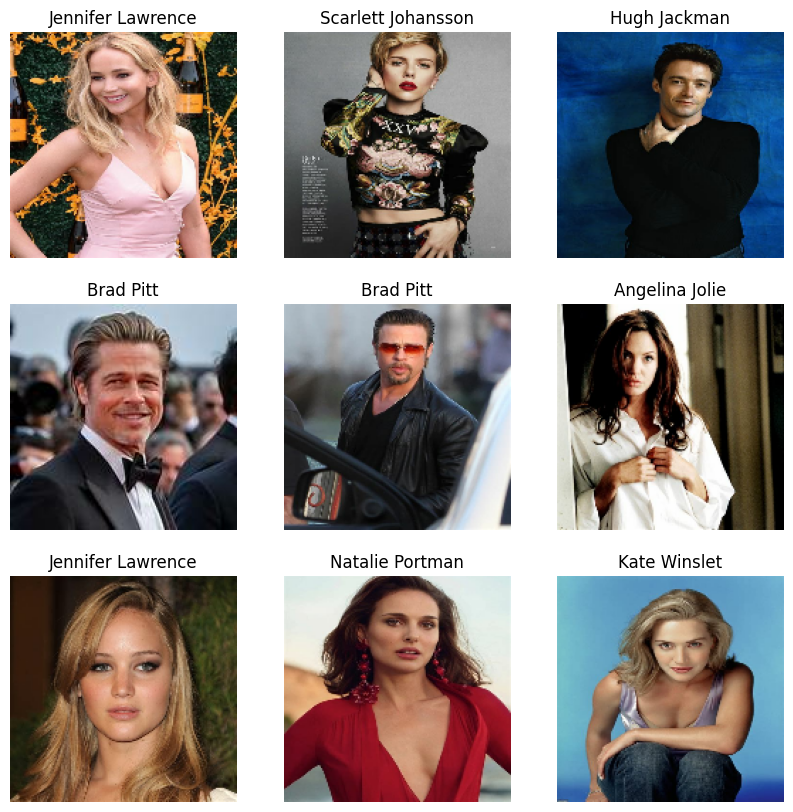

In [ ]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.argmax(predictions, axis=-1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")